In [66]:
using Revise
using QuantumGraining
using QuantumCumulants
using QuantumOptics
using Symbolics
using OrdinaryDiffEq
using ModelingToolkit
using LaTeXStrings
using Plots

# Time-coarse grained Rabi model

To demonstrate the use of the method, we start with a simple but illustrative example -- the Rabi model. The Rabi model describes the interaction of a single field mode interacting with a two-level system. However, unlike the Jaynes-Cummings model, it does not assume the rotating-wave approximation (RWA). More concretely, the model is described by the following Hamiltonian terms in the interaction picture,

$$
    \begin{align*}
    &g_{\Omega}
    =
    \{\frac{g}{2}, \frac{g}{2}, \frac{g}{2}, \frac{g}{2}\} \\
    &h_{\Omega}
    =
    \{\hat{a}\hat{\sigma}_-, \hat{a}^\dagger \hat{\sigma}_+, \hat{a}\hat{\sigma}_+, \hat{a}^\dagger \hat{\sigma_-} \} \\
    &\Omega
    =
    \{
    - \big( \omega_c + \omega_a \big),
    \omega_c + \omega_a,
    - \omega_c + \omega_a,
    \omega_c - \omega_a
    \} \\
    &\hat{H} = \sum_{\omega \in \Omega} g_\omega h_\omega e^{-i\omega t}
\end{align*}
$$

We start by coding in the Hamiltonian. We use `QuantumCumulants` to handle the operator algebra, a `Symbolics` for handling the symbolic calculations.

In [67]:
@variables g ωc ωa
Ω = [-ωc - ωa, ωc + ωa, -ωc + ωa, ωc - ωa]
gvec = (g/2).*[1, 1, 1, 1]

# Hilbert space definitions (QuantumCumulants.jl)
h_cav = FockSpace(:cavity)
h_atom = NLevelSpace(:atom, (:g,:e))
h = tensor(h_cav, h_atom)

# Operator definitions
@qnumbers a::Destroy(h) σ::Transition(h)
σm = σ(:e, :g)
σp = σ(:g, :e)
hvec = [a*σm, a'*σp, a*σp, a'*σm]

4-element Vector{QuantumCumulants.QMul{Nothing}}:
 (a*σeg)
 (a′*σge)
 (a*σge)
 (a′*σeg)

## First-order time-coarse graining - the JC model

To first-order the corrections are only Hermitian, and depend on a single contraction coefficient.

$$
    C_{1,0}(\omega) = e^{- \frac{\omega^2 \tau^2}{2}}
$$

We can calculate the first-order by hand, and compare it to the results obtained by `QuantumGraining.jl`. For brevity, let us denote,
$$
    \overline{\omega} = \omega_c + \omega_a \rightarrow \hat{a}^\dagger \hat{\sigma}_+ \\
    \Delta = \omega_c - \omega_a \rightarrow \hat{a}^\dagger \sigma_-
$$

Collecting the relevant corrections,
$$
    \overline{\omega}: \ \ \ g_{a^\dagger \sigma_+} = \frac{g}{2} e^{-\frac{\overline{\omega}^2\tau^2}{2}} \approx 0 \\
    \Delta: \ \ \ g_{a^\dagger \sigma_-} = \frac{g}{2} e^{-\frac{\Delta^2\tau^2}{2}} \approx \frac{g}{2} \\
    -\Delta: \ \ \ g_{a \sigma_+} = \frac{g}{2} e^{-\frac{\Delta^2\tau^2}{2}} \approx \frac{g}{2}\\
    -\overline{\omega}: \ \ \ g_{a \sigma_-} = e^{-\frac{\overline{\omega}^2\tau^2}{2}} \approx 0
$$
which approximately gives the RWA Hamiltonian (it would be given directly for a cutoff filter).
$$
    H^{(1)} = \frac{g}{2} \left ( \hat{a}^\dagger \hat{\sigma}_- e^{i\Delta t} + \hat{a}\sigma_+ e^{-i\Delta t}\right )
$$



Equivalently, let us also do that by calling the `effective_hamiltonian_term` function, which calculates a single order of the TCG Hamiltonian.

In [68]:
#ops_eff_1, g_eff_1, Ω_eff_1 = effective_hamiltonian_term(hvec, gvec, Ω, 1)

# We can also call `effective_hamiltonian`, which gives the full Hamiltonian to a given order.
# To first order these are the same.
g_eff_1, Ω_eff_1 = effective_hamiltonian(hvec, gvec, Ω, 1; as_dict=true)

(Dict{QuantumCumulants.QMul{Nothing}, ContractionCoefficient}((a*σge) => 0.5g*exp(-0.5(τ^2)*((ωa - ωc)^2)), (a′*σeg) => 0.5g*exp(-0.5(τ^2)*((ωc - ωa)^2)), (a′*σge) => 0.5g*exp(-0.5(τ^2)*((ωa + ωc)^2)), (a*σeg) => 0.5g*exp(-0.5(τ^2)*((-ωa - ωc)^2))), Dict{QuantumCumulants.QMul{Nothing}, Num}((a*σge) => ωa - ωc, (a′*σeg) => ωc - ωa, (a′*σge) => ωa + ωc, (a*σeg) => -ωa - ωc))

In [69]:
g_eff_1  

Dict{QuantumCumulants.QMul{Nothing}, ContractionCoefficient} with 4 entries:
  (a*σge)  => 0.5g*exp(-0.5(τ^2)*((ωa - ωc)^2))
  (a′*σeg) => 0.5g*exp(-0.5(τ^2)*((ωc - ωa)^2))
  (a′*σge) => 0.5g*exp(-0.5(τ^2)*((ωa + ωc)^2))
  (a*σeg)  => 0.5g*exp(-0.5(τ^2)*((-ωa - ωc)^2))

In [70]:
Ω_eff_1

Dict{QuantumCumulants.QMul{Nothing}, Num} with 4 entries:
  (a*σge)  => ωa - ωc
  (a′*σeg) => ωc - ωa
  (a′*σge) => ωa + ωc
  (a*σeg)  => -ωa - ωc

To visualize the result, it is useful to use the `symbolic_hamiltonian` function, which renders the Hamiltonian in Latex.

In [71]:
@variables t τ  # define symbolic variables for displaying
H_1 = sum(symbolic_hamiltonian(g_eff_1, Ω_eff_1, t, τ))

(0.5g*exp(-0.5(τ^2)*((ωa - ωc)^2))*exp(im*t*(ωa - ωc))*(a*σge)+0.5g*exp(im*t*(ωc - ωa))*exp(-0.5(τ^2)*((ωc - ωa)^2))*(a′*σeg)+0.5g*exp(-0.5(τ^2)*((ωa + ωc)^2))*exp(im*t*(ωa + ωc))*(a′*σge)+0.5g*exp(im*t*(-ωa - ωc))*exp(-0.5(τ^2)*((-ωa - ωc)^2))*(a*σeg))

The results are a little bit hard to read, since they include also high-frequency terms weighted by the Gaussian filter. We can simplify the comparison to the RWA by replacing the Gaussian filter by a cutoff filter.

Since $\omega_c$ and $\omega_a$ are just symbols, we need to give them a value to decide whether an expression is high-frequency or not.

In [72]:
freqs_subs = Dict(
    ωa => 1,
    ωc => 1.01
)
g_low_1, Ω_low_1 = drop_high_freqs(g_eff_1, Ω_eff_1, freqs_subs)

(Dict{QuantumCumulants.QMul{Nothing}, ContractionCoefficient}((a*σge) => 0.5g*exp(-0.5(τ^2)*((ωa - ωc)^2)), (a′*σeg) => 0.5g*exp(-0.5(τ^2)*((ωc - ωa)^2))), Dict{QuantumCumulants.QMul{Nothing}, Num}((a*σge) => ωa - ωc, (a′*σeg) => ωc - ωa))

With that, we can drop the high-frquency terms using `drop_high_freqs`. We can also call the function `gaussian_to_cutoff` to remove completely any high-frequency terms.

In [73]:
g_low_1 = gaussian_to_cutoff(g_eff_1, Ω_low_1, freqs_subs; keep_small_exponents=false)

Dict{QuantumCumulants.QMul{Nothing}, ContractionCoefficient} with 2 entries:
  (a*σge)  => 0.5g
  (a′*σeg) => 0.5g

In [74]:
H_low_1 = sum(symbolic_hamiltonian(g_low_1, Ω_low_1, t, τ))

(0.5g*exp(im*t*(ωa - ωc))*(a*σge)+0.5g*exp(im*t*(ωc - ωa))*(a′*σeg))

which is exactly the RWA Hamiltonian.

## Second-order time-coarse graining

To second-order, this we have two contraction coefficients.
$$
    C_{2,0}(\omega, \omega') = -C_{1,1}(\omega, \omega') = f(\omega, \omega') \\
    f(\omega, \omega') = \frac{1}{\omega'} \left [ e^{-\frac{\omega^2 + \omega'^2}{2}\tau^2} - e^{-\frac{(\omega + \omega')^2\tau^2}{2}} \right ]
$$

where we also have the following symmetries,
$$
    f(\omega, \omega') = \frac{\omega}{\omega'} f(\omega', \omega) \\
    f(\omega, -\omega') = -f(\omega, \omega')
$$

### Hamiltonian contributions

In [75]:
g_eff_2, Ω_eff_2 = effective_hamiltonian(hvec, gvec, Ω, 2; as_dict=true)

(Dict{Any, ContractionCoefficient}(σee => (-ωa*(g^2)) / (2(ωa + ωc)*(ωc - ωa)) + (0.25(g^2)*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))) / (ωc - ωa) + (-0.25(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa - ωc)^2))) / (ωa + ωc), (a*a) => (0.25ωa*(g^2)*exp(-0.5(τ^2)*((ωa - ωc)^2 + (-ωa - ωc)^2))) / ((ωc - ωa)*(-ωa - ωc)) + (-ωa*(g^2)*exp(-2.0(τ^2)*(ωc^2))) / (4(ωc - ωa)*(-ωa - ωc)), (a*σge) => 0.5g*exp(-0.5(τ^2)*((ωa - ωc)^2)), (a′*σeg) => 0.5g*exp(-0.5(τ^2)*((ωc - ωa)^2)), (a′*σge) => 0.5g*exp(-0.5(τ^2)*((ωa + ωc)^2)), (a*a*σee) => (-ωa*(g^2)*exp(-2.0(τ^2)*(ωc^2))) / (2(ωa - ωc)*(-ωa - ωc)) + (0.5ωa*(g^2)*exp(-0.5(τ^2)*((ωa - ωc)^2 + (-ωa - ωc)^2))) / ((ωa - ωc)*(-ωa - ωc)), (a′*a′) => (0.25ωa*(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (ωc - ωa)^2))) / ((ωc - ωa)*(-ωa - ωc)) + (-ωa*(g^2)*exp(-2.0(τ^2)*(ωc^2))) / (4(ωc - ωa)*(-ωa - ωc)), (a′*a*σee) => (0.5(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa - ωc)^2))) / (-ωa - ωc) + (-ωa*(g^2)) / ((ωa - ωc)*(-ωa - ωc)) + (-0.5(g^2)*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa -

In [76]:
g_eff_2

Dict{Any, ContractionCoefficient} with 11 entries:
  σee         => (-ωa*(g^2)) / (2(ωa + ωc)*(ωc - ωa)) + (0.25(g^2)*exp(-0.5(τ^2…
  (a*a)       => (0.25ωa*(g^2)*exp(-0.5(τ^2)*((ωa - ωc)^2 + (-ωa - ωc)^2))) / (…
  (a*σge)     => 0.5g*exp(-0.5(τ^2)*((ωa - ωc)^2))
  (a′*σeg)    => 0.5g*exp(-0.5(τ^2)*((ωc - ωa)^2))
  (a′*σge)    => 0.5g*exp(-0.5(τ^2)*((ωa + ωc)^2))
  (a*a*σee)   => (-ωa*(g^2)*exp(-2.0(τ^2)*(ωc^2))) / (2(ωa - ωc)*(-ωa - ωc)) + …
  (a′*a′)     => (0.25ωa*(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (ωc - ωa)^2))) / ((…
  (a′*a*σee)  => (0.5(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa - ωc)^2))) / (-ωa …
  (a′*a′*σee) => (-ωa*(g^2)*exp(-2.0(τ^2)*(ωc^2))) / (2(ωa - ωc)*(-ωa - ωc)) + …
  (a′*a)      => (-0.25(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa - ωc)^2))) / (-ω…
  (a*σeg)     => 0.5g*exp(-0.5(τ^2)*((-ωa - ωc)^2))

In [77]:
to_symbol(g_eff_2[a'*a], τ) # => g_eff_2[a'*a]*a'*a

(-0.25(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa - ωc)^2))) / (-ωa - ωc) + (-ωa*(g^2)) / (2(ωc - ωa)*(-ωa - ωc)) + (-0.25(g^2)*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))) / (ωc - ωa)

In [78]:
Ω_eff_2

Dict{Any, Num} with 11 entries:
  σee         => 0.0
  (a*a)       => -2ωc
  (a*σge)     => ωa - ωc
  (a′*σeg)    => ωc - ωa
  (a′*σge)    => ωa + ωc
  (a*a*σee)   => -2ωc
  (a′*a′)     => 2ωc
  (a′*a*σee)  => 0.0
  (a′*a′*σee) => 2ωc
  (a′*a)      => 0.0
  (a*σeg)     => -ωa - ωc

Most terms vanish simply due to the operators falling outside of the two-level manifold, i.e. $\hat{\sigma}_{\pm} \hat{\sigma}_{\pm} = 0$. The surviving terms would correspond to the following frequnecy pairs $\{ (\overline{\omega}, \Delta), (\overline{\omega}, -\overline{\omega}), (\Delta, -\Delta), (-\overline{\omega}, -\Delta) \}$, as well as their conjugates.

The coupling strengths are related to the contraction coefficients by the following symmetries,
$$
    g(\omega, -\omega) = f(\omega, -\omega) + f(\omega, -\omega) = 2f(\omega, -\omega) \\
    g(-\omega, \omega) = f(-\omega, \omega) + f(-\omega, \omega) = -2f(\omega, -\omega) \\
    g(\omega, -\omega) = -g(-\omega, \omega)
$$

The coupling strengths are calculated directly from the contraction coefficients and are given by,
$$
    g_{\overline{\omega}, \Delta} = \left ( \frac{1}{\Delta} - \frac{1}{\overline{\omega}} \right ) \left [ e^{- \frac{\overline{\omega}^2 + \Delta^2}{2} \tau^2} - e^{- \frac{(\overline{\omega} + \Delta)^2\tau^2}{2}}\right ] \approx 0 \\

    g_{\overline{\omega}, -\overline{\omega}} = \frac{2}{\overline{\omega}} \left [ e^{-\overline{\omega}^2 \tau^2} - 1 \right ] \approx - \frac{2}{\overline{\omega}} \\

    g_{\Delta, -\Delta} = \frac{2}{\Delta} \left [ e^{-\Delta^2 \tau^2} - 1\right ] \approx -2\tau^2 \Delta \\

    g_{\Delta, -\overline{\omega}} = \left ( \frac{1}{\Delta} - \frac{1}{\overline{\omega}} \right ) \left [ e^{- \frac{\overline{\omega}^2 + \Delta^2}{2} \tau^2} - e^{- \frac{(\overline{\omega} + \Delta)^2\tau^2}{2}}\right ] \approx 0 \\
$$

We can again compare with the coefficients obtained using `QuantumGraining.jl`. We first look at the frequencies of the different terms, as well as the different coupling corresponding to them.

Again, the full expression is very busy and hard to dechiper. As before, let us simplify the weights and drop high-frequency terms.

In [79]:
freqs_subs = Dict(
    ωa => 1,
    ωc => 1.01
)
g_low_2, Ω_low_2 = drop_high_freqs(g_eff_2, Ω_eff_2, freqs_subs)

(Dict{Any, ContractionCoefficient}(σee => (-ωa*(g^2)) / (2(ωa + ωc)*(ωc - ωa)) + (0.25(g^2)*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))) / (ωc - ωa) + (-0.25(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa - ωc)^2))) / (ωa + ωc), (a*σge) => 0.5g*exp(-0.5(τ^2)*((ωa - ωc)^2)), (a′*σeg) => 0.5g*exp(-0.5(τ^2)*((ωc - ωa)^2)), (a′*a*σee) => (0.5(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa - ωc)^2))) / (-ωa - ωc) + (-ωa*(g^2)) / ((ωa - ωc)*(-ωa - ωc)) + (-0.5(g^2)*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))) / (ωa - ωc), (a′*a) => (-0.25(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa - ωc)^2))) / (-ωa - ωc) + (-ωa*(g^2)) / (2(ωc - ωa)*(-ωa - ωc)) + (-0.25(g^2)*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))) / (ωc - ωa)), Dict{Any, Num}(σee => 0.0, (a*σge) => ωa - ωc, (a′*σeg) => ωc - ωa, (a′*a*σee) => 0.0, (a′*a) => 0.0))

In [80]:
g_low_2 = gaussian_to_cutoff(g_eff_2, Ω_low_2, freqs_subs; keep_small_exponents=true)

Dict{QuantumCumulants.QNumber, ContractionCoefficient} with 5 entries:
  σee        => (-ωa*(g^2)) / (2(ωa + ωc)*(ωc - ωa)) + (0.25(g^2)*exp(-0.5(τ^2)…
  (a*σge)    => 0.5g*exp(-0.5(τ^2)*((ωa - ωc)^2))
  (a′*σeg)   => 0.5g*exp(-0.5(τ^2)*((ωc - ωa)^2))
  (a′*a*σee) => (-ωa*(g^2)) / ((ωa - ωc)*(-ωa - ωc)) + (-0.5(g^2)*exp(-0.5(τ^2)…
  (a′*a)     => (-ωa*(g^2)) / (2(ωc - ωa)*(-ωa - ωc)) + (-0.25(g^2)*exp(-0.5(τ^…

We can order the couplings according to the operators,
$$
    g_{\hat{a}^\dagger \hat{a}} = g_2 - g_1 = -g_{TCG}\\
    g_{|e\rangle \langle e|} = g_1 - g_2 = g_{TCG}\\
    g_{\hat{a}^\dagger \hat{a} |e\rangle \langle e|} = 2(g_1 - g_2) = 2g_{TCG}
$$
where,
$$
    g_1 = \frac{1}{\overline{\omega}} \left [ e^{-\overline{\omega}^2 \tau^2} - 1 \right ] \\
    g_2 = \left [ e^{-\Delta^2 \tau^2} - 1 \right ] \frac{1}{\Delta} 
$$

We find that the second order contribution is,

$$
    \hat{H}^{(2)} =  g_{TCG} (\hat{a}^\dagger \hat{a} - |e\rangle\langle e| - 2\hat{a}^\dagger\hat{a}|e\rangle\langle e|)
$$

or in terms of $\hat{\sigma}_z = 1 - 2|e\rangle \langle e|$,
$$
    \hat{H}^{(2)} = (\hat{a}^\dagger \hat{a} - \frac{1}{2}(1 - \hat{\sigma}_z) - (\hat{a}^\dagger\hat{a} - \hat{a}^\dagger \hat{a} \hat{\sigma}_z)) = \frac{1}{2} g_{TCG} \left (\hat{\sigma}_z + 2\hat{a}^\dagger\hat{a} \hat{\sigma}_z \right )
$$

To simplify the expressions further, we remove the exponentially suppressed terms.

In [81]:
to_symbol.(values(g_low_2), τ)

5-element Vector{Num}:
   (-ωa*(g^2)) / (2(ωa + ωc)*(ωc - ωa)) + (0.25(g^2)*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))) / (ωc - ωa)
                                           0.5g*exp(-0.5(τ^2)*((ωa - ωc)^2))
                                           0.5g*exp(-0.5(τ^2)*((ωc - ωa)^2))
  (-ωa*(g^2)) / ((ωa - ωc)*(-ωa - ωc)) + (-0.5(g^2)*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))) / (ωa - ωc)
 (-ωa*(g^2)) / (2(ωc - ωa)*(-ωa - ωc)) + (-0.25(g^2)*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))) / (ωc - ωa)

Thus we see that the second-order contribution changes the resonant frequencies of the qubit and the resonator, while also inducing an apparent longitudinal coupling between them.

### The TCG Dissipators

In addition, in second order we also have dissipators generated by the method.

In [82]:
γ_eff_2, ω_eff_2 = effective_dissipator(hvec, gvec, Ω, 2)

(Dict{Tuple{QuantumCumulants.QMul{Nothing}, QuantumCumulants.QMul{Nothing}}, ContractionCoefficient}(((a*σge), (a*σge)) => im*((-0.5(g^2)*exp(-(τ^2)*((ωa - ωc)^2))) / (ωa - ωc) + (0.5(g^2)*exp(-2.0(τ^2)*((ωa - ωc)^2))) / (ωa - ωc)), ((a′*σge), (a*σge)) => im*((-ωa*(g^2)*exp(-0.5((ωa + ωc)^2 + (ωa - ωc)^2 + 2(ωa + ωc)*(ωa - ωc))*(τ^2))) / (2(ωa - ωc)*(-ωa - ωc)) + (0.5ωa*(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (ωa - ωc)^2))) / ((ωa - ωc)*(-ωa - ωc))), ((a′*σeg), (a*σge)) => 0.0, ((a′*σeg), (a′*σeg)) => im*((0.5(g^2)*exp(-(τ^2)*((ωc - ωa)^2))) / (ωa - ωc) + (-0.5(g^2)*exp(-2.0(τ^2)*((ωc - ωa)^2))) / (ωa - ωc)), ((a′*σeg), (a′*σge)) => im*((-ωc*(g^2)*exp(-0.5((ωa + ωc)^2 + (ωc - ωa)^2 + 2(ωa + ωc)*(ωc - ωa))*(τ^2))) / (2(ωa + ωc)*(ωa - ωc)) + (0.5ωc*(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (ωc - ωa)^2))) / ((ωa + ωc)*(ωa - ωc))), ((a*σge), (a′*σge)) => im*((0.5ωa*(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (ωa - ωc)^2))) / ((ωa + ωc)*(ωc - ωa)) + (-ωa*(g^2)*exp(-0.5((ωa + ωc)^2 + (ωa - ωc)^2 + 2(ωa + ωc)*(ωa

In [83]:
γ_eff_2

Dict{Tuple{QuantumCumulants.QMul{Nothing}, QuantumCumulants.QMul{Nothing}}, ContractionCoefficient} with 16 entries:
  ((a*σge), (a*σge))   => im*((-0.5(g^2)*exp(-(τ^2)*((ωa - ωc)^2))) / (ωa - ωc)…
  ((a′*σge), (a*σge))  => im*((-ωa*(g^2)*exp(-0.5((ωa + ωc)^2 + (ωa - ωc)^2 + 2…
  ((a′*σeg), (a*σge))  => 0.0
  ((a′*σeg), (a′*σeg)) => im*((0.5(g^2)*exp(-(τ^2)*((ωc - ωa)^2))) / (ωa - ωc) …
  ((a′*σeg), (a′*σge)) => im*((-ωc*(g^2)*exp(-0.5((ωa + ωc)^2 + (ωc - ωa)^2 + 2…
  ((a*σge), (a′*σge))  => im*((0.5ωa*(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (ωa - ω…
  ((a*σge), (a′*σeg))  => 0.0
  ((a*σeg), (a*σeg))   => im*((-0.5(g^2)*exp(-(τ^2)*((-ωa - ωc)^2))) / (-ωa - ω…
  ((a*σeg), (a′*σge))  => 0.0
  ((a′*σge), (a′*σge)) => im*((0.5(g^2)*exp(-(τ^2)*((ωa + ωc)^2))) / (-ωa - ωc)…
  ((a*σeg), (a′*σeg))  => im*((ωa*(g^2)*exp(-0.5((ωc - ωa)^2 + (-ωa - ωc)^2 + 2…
  ((a′*σge), (a*σeg))  => 0.0
  ((a′*σeg), (a*σeg))  => im*((ωa*(g^2)*exp(-0.5((ωc - ωa)^2 + (-ωa - ωc)^2 + 2…
  ((a*σeg), (a*σge))   => im*((ωc*

In [84]:
ω_eff_2

Dict{Tuple{QuantumCumulants.QMul{Nothing}, QuantumCumulants.QMul{Nothing}}, Num} with 16 entries:
  ((a*σge), (a*σge))   => 2ωa - 2ωc
  ((a′*σge), (a*σge))  => 2ωa
  ((a′*σeg), (a*σge))  => 0
  ((a′*σeg), (a′*σeg)) => 2ωc - 2ωa
  ((a′*σeg), (a′*σge)) => 2ωc
  ((a*σge), (a′*σge))  => 2ωa
  ((a*σge), (a′*σeg))  => 0
  ((a*σeg), (a*σeg))   => -2ωa - 2ωc
  ((a*σeg), (a′*σge))  => 0
  ((a′*σge), (a′*σge)) => 2ωa + 2ωc
  ((a*σeg), (a′*σeg))  => -2ωa
  ((a′*σge), (a*σeg))  => 0
  ((a′*σeg), (a*σeg))  => -2ωa
  ((a*σeg), (a*σge))   => -2ωc
  ((a′*σge), (a′*σeg)) => 2ωc
  ((a*σge), (a*σeg))   => -2ωc

Again, to simplify we drop high-frequency terms,

In [85]:
freqs_subs = Dict(
    ωa => 1,
    ωc => 1.01
)
γ_low_2, Ω_low_2 = drop_high_freqs(γ_eff_2, ω_eff_2, freqs_subs)

(Dict{Tuple{QuantumCumulants.QMul{Nothing}, QuantumCumulants.QMul{Nothing}}, ContractionCoefficient}(((a*σge), (a*σge)) => im*((-0.5(g^2)*exp(-(τ^2)*((ωa - ωc)^2))) / (ωa - ωc) + (0.5(g^2)*exp(-2.0(τ^2)*((ωa - ωc)^2))) / (ωa - ωc)), ((a′*σeg), (a*σge)) => 0.0, ((a′*σeg), (a′*σeg)) => im*((0.5(g^2)*exp(-(τ^2)*((ωc - ωa)^2))) / (ωa - ωc) + (-0.5(g^2)*exp(-2.0(τ^2)*((ωc - ωa)^2))) / (ωa - ωc)), ((a*σge), (a′*σeg)) => 0.0, ((a*σeg), (a′*σge)) => 0.0, ((a′*σge), (a*σeg)) => 0.0), Dict{Tuple{QuantumCumulants.QMul{Nothing}, QuantumCumulants.QMul{Nothing}}, Num}(((a*σge), (a*σge)) => 2ωa - 2ωc, ((a′*σeg), (a*σge)) => 0, ((a′*σeg), (a′*σeg)) => 2ωc - 2ωa, ((a*σge), (a′*σeg)) => 0, ((a*σeg), (a′*σge)) => 0, ((a′*σge), (a*σeg)) => 0))

In [86]:
γ_low_2 = gaussian_to_cutoff(γ_eff_2, Ω_low_2, freqs_subs, keep_small_exponents=true)

Dict{Tuple{QuantumCumulants.QMul{Nothing}, QuantumCumulants.QMul{Nothing}}, ContractionCoefficient} with 6 entries:
  ((a*σge), (a*σge))   => im*((-0.5(g^2)*exp(-(τ^2)*((ωa - ωc)^2))) / (ωa - ωc)…
  ((a′*σge), (a*σeg))  => 0
  ((a′*σeg), (a′*σeg)) => im*((0.5(g^2)*exp(-(τ^2)*((ωc - ωa)^2))) / (ωa - ωc) …
  ((a′*σeg), (a*σge))  => 0
  ((a*σge), (a′*σeg))  => 0.0
  ((a*σeg), (a′*σge))  => 0.0

## Solving the TCG model using `QuantumOptics.jl`

`QuantumGraining.jl` can be seamlessly integrated with `QuantumCumulants.jl` and `QuantumOptics.jl`. We will use that integration to solve the quantum systems we obtained. We start by defining the `QuantumOptics.jl` variables.

In [87]:
# Units
μs = 1
MHz = 1/μs

### QuantumOptics.jl definitions
ha_qo = SpinBasis(1//2)
hc_qo = FockBasis(400)
h_qo = hc_qo ⊗ ha_qo

# Operator definitions
σp_qo = sigmap(ha_qo)
σm_qo = sigmam(ha_qo)
a_qo = destroy(hc_qo)
I_a = identityoperator(ha_qo)
I_c = identityoperator(hc_qo)

p_sym = [g, ωc, ωa]

3-element Vector{Num}:
  g
 ωc
 ωa

In [88]:
g_eff_1, Ω_eff_1 = drop_high_freqs(effective_hamiltonian(hvec, gvec, Ω, 1; as_dict=true)..., freqs_subs)
g_eff_2, Ω_eff_2 = drop_high_freqs(effective_hamiltonian(hvec, gvec, Ω, 2; as_dict=true)..., freqs_subs)

(Dict{Any, ContractionCoefficient}(σee => (-ωa*(g^2)) / (2(ωa + ωc)*(ωc - ωa)) + (0.25(g^2)*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))) / (ωc - ωa) + (-0.25(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa - ωc)^2))) / (ωa + ωc), (a*σge) => 0.5g*exp(-0.5(τ^2)*((ωa - ωc)^2)), (a′*σeg) => 0.5g*exp(-0.5(τ^2)*((ωc - ωa)^2)), (a′*a*σee) => (0.5(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa - ωc)^2))) / (-ωa - ωc) + (-ωa*(g^2)) / ((ωa - ωc)*(-ωa - ωc)) + (-0.5(g^2)*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))) / (ωa - ωc), (a′*a) => (-0.25(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa - ωc)^2))) / (-ωa - ωc) + (-ωa*(g^2)) / (2(ωc - ωa)*(-ωa - ωc)) + (-0.25(g^2)*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))) / (ωc - ωa)), Dict{Any, Num}(σee => 0.0, (a*σge) => ωa - ωc, (a′*σeg) => ωc - ωa, (a′*a*σee) => 0.0, (a′*a) => 0.0))

In [89]:
γ_eff_2, ω_eff_2 = drop_high_freqs(effective_dissipator(hvec, gvec, Ω, 2; as_dict=true)..., freqs_subs)

(Dict{Tuple{QuantumCumulants.QMul{Nothing}, QuantumCumulants.QMul{Nothing}}, ContractionCoefficient}(((a*σge), (a*σge)) => im*((-0.5(g^2)*exp(-(τ^2)*((ωa - ωc)^2))) / (ωa - ωc) + (0.5(g^2)*exp(-2.0(τ^2)*((ωa - ωc)^2))) / (ωa - ωc)), ((a′*σeg), (a*σge)) => 0.0, ((a′*σeg), (a′*σeg)) => im*((0.5(g^2)*exp(-(τ^2)*((ωc - ωa)^2))) / (ωa - ωc) + (-0.5(g^2)*exp(-2.0(τ^2)*((ωc - ωa)^2))) / (ωa - ωc)), ((a*σge), (a′*σeg)) => 0.0, ((a*σeg), (a′*σge)) => 0.0, ((a′*σge), (a*σeg)) => 0.0), Dict{Tuple{QuantumCumulants.QMul{Nothing}, QuantumCumulants.QMul{Nothing}}, Num}(((a*σge), (a*σge)) => 2ωa - 2ωc, ((a′*σeg), (a*σge)) => 0, ((a′*σeg), (a′*σeg)) => 2ωc - 2ωa, ((a*σge), (a′*σeg)) => 0, ((a*σeg), (a′*σge)) => 0, ((a′*σge), (a*σeg)) => 0))

In [90]:
g_eff_3, Ω_eff_3 = drop_high_freqs(effective_hamiltonian(hvec, gvec, Ω, 3; as_dict=true)..., freqs_subs)

(Dict{Any, ContractionCoefficient}(σee => (-ωa*(g^2)) / (2(ωa + ωc)*(ωc - ωa)) + (0.25(g^2)*exp(-0.5(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))) / (ωc - ωa) + (-0.25(g^2)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (-ωa - ωc)^2))) / (ωa + ωc), (a*σge) => ((1 + (-0.25ωc*(g^2)*(τ^2)*(ωa + ωc)*((ωc - ωa)^2)) / (ωc^4 + ωc*(ωa^3) + 0.125(g^2)*(ωc^2) + 0.5ωa*ωc*(g^2) - ωa*(ωc^3) - 0.125(g^2)*(ωa^2) - (ωa^2)*(ωc^2)))*(g*(ωc^4) + g*ωc*(ωa^3) + 0.125(g^3)*(ωc^2) + 0.5ωa*ωc*(g^3) - 0.125(g^3)*(ωa^2) - g*ωa*(ωc^3) - g*(ωa^2)*(ωc^2))*exp(-0.5(τ^2)*((ωa - ωc)^2))) / (2ωc*(ωa + ωc)*((ωc - ωa)^2)) + (0.125(g^3)*exp(-0.5(τ^2)*((ωc - ωa)^2 + 2((ωa - ωc)^2)))) / ((ωc - ωa)*(ωa - ωc)) + ((1 + (-0.25ωc*(g^2)*(τ^2)*(ωa + ωc)*((ωc - ωa)^2)) / (ωc^4 + ωc*(ωa^3) + 0.125(g^2)*(ωc^2) + 0.5ωa*ωc*(g^2) - ωa*(ωc^3) - 0.125(g^2)*(ωa^2) - (ωa^2)*(ωc^2)))*(ωa^2 + 4.0ωa*ωc - (ωc^2))*(g^3)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (4//1)*(ωc^2)))) / (16ωc*(ωa + ωc)*(ωc - ωa)*(-ωa - ωc)) + (-0.25ωa*(g^3)*(1 + (-0.25ωc*(g^2)*(τ^2)*(ωa + ωc)*((ωc - ωa)^2)) /

In [91]:
# can take long to run
g_eff_4, Ω_eff_4 = drop_high_freqs(effective_hamiltonian(hvec, gvec, Ω, 4; as_dict=true)..., freqs_subs)

(Dict{Any, ContractionCoefficient}((a*σge) => ((1 + (-0.25ωc*(g^2)*(τ^2)*(ωa + ωc)*((ωc - ωa)^2)) / (ωc^4 + ωc*(ωa^3) + 0.125(g^2)*(ωc^2) + 0.5ωa*ωc*(g^2) - ωa*(ωc^3) - 0.125(g^2)*(ωa^2) - (ωa^2)*(ωc^2)))*(g*(ωc^4) + g*ωc*(ωa^3) + 0.125(g^3)*(ωc^2) + 0.5ωa*ωc*(g^3) - 0.125(g^3)*(ωa^2) - g*ωa*(ωc^3) - g*(ωa^2)*(ωc^2))*exp(-0.5(τ^2)*((ωa - ωc)^2))) / (2ωc*(ωa + ωc)*((ωc - ωa)^2)) + (0.125(g^3)*exp(-0.5(τ^2)*((ωc - ωa)^2 + 2((ωa - ωc)^2)))) / ((ωc - ωa)*(ωa - ωc)) + ((1 + (-0.25ωc*(g^2)*(τ^2)*(ωa + ωc)*((ωc - ωa)^2)) / (ωc^4 + ωc*(ωa^3) + 0.125(g^2)*(ωc^2) + 0.5ωa*ωc*(g^2) - ωa*(ωc^3) - 0.125(g^2)*(ωa^2) - (ωa^2)*(ωc^2)))*(ωa^2 + 4.0ωa*ωc - (ωc^2))*(g^3)*exp(-0.5(τ^2)*((ωa + ωc)^2 + (4//1)*(ωc^2)))) / (16ωc*(ωa + ωc)*(ωc - ωa)*(-ωa - ωc)) + (-0.25ωa*(g^3)*(1 + (-0.25ωc*(g^2)*(τ^2)*(ωa + ωc)*((ωc - ωa)^2)) / (ωc^4 + ωc*(ωa^3) + 0.125(g^2)*(ωc^2) + 0.5ωa*ωc*(g^2) - ωa*(ωc^3) - 0.125(g^2)*(ωa^2) - (ωa^2)*(ωc^2)))*exp(-0.5((ωa + ωc)^2 + (ωa - ωc)^2 + (-ωa - ωc)^2)*(τ^2))) / ((ωa + ωc)*(ωc - ω

In [92]:
g_eff_4

Dict{Any, ContractionCoefficient} with 9 entries:
  (a*σge)         => ((1 + (-0.25ωc*(g^2)*(τ^2)*(ωa + ωc)*((ωc - ωa)^2)) / (ωc^…
  σee             => ((-0.125(g^4)) / ((ωa + ωc)*(ωc - ωa)*(-ωa - ωc)) + (0.5(ω…
  (a′*a′*a*σeg)   => (0.125(g^3)*exp(-0.5(τ^2)*((ωa - ωc)^2 + 2((ωc - ωa)^2))))…
  (a′*a′*a*a*σee) => (g^4) / (32ωc*((ωa + ωc)^2)) + (g^4) / (32ωc*((-ωa - ωc)^2…
  (a′*σeg)        => ((1 + (-0.25ωc*(g^2)*(τ^2)*(ωa + ωc)*((ωc - ωa)^2)) / (ωc^…
  (a′*a*a*σge)    => (0.125(g^3)*exp(-0.5(τ^2)*((ωc - ωa)^2 + 2((ωa - ωc)^2))))…
  (a′*a′*a*a)     => (g^4) / (32ωc*((ωc - ωa)^2)) + ((-1//16)*(g^4)) / ((ωc - ω…
  (a′*a*σee)      => (0.25((0.1875(g^4)) / ((ωa - ωc)*((ωc - ωa)^2)) + (-Inf*(g…
  (a′*a)          => (-(g^4)*exp(-4.0(τ^2)*(ωc^2))) / (8ωc*(ωc - ωa)*(-ωa - ωc)…

In [93]:
g_eff_4[a'*a'*a*a]

(g^4) / (32ωc*((ωc - ωa)^2)) + ((-1//16)*(g^4)) / ((ωc - ωa)^3) + ((-1//16)*(g^4)) / ((-ωa - ωc)^3) + (-(g^4)) / (32ωc*((-ωa - ωc)^2)) + (-0.0625(g^4)*exp(-(τ^2)*((ωc - ωa)^2 + (ωa - ωc)^2))) / ((ωa - ωc)*((ωc - ωa)^2)) + (0.125ωa*(g^4)) / (((ωc - ωa)^2)*((-ωa - ωc)^2)) + (-0.25(1 + (-0.25(τ^2)*((-768.0((ωa - ωc)^2)*((-3.0(g^4)*(ωc - ωa)*((-ωa - ωc)^2)) / (-128.0ωa*(ωa - ωc)*(-(ωa^2) - (ωc^2) - 4.0ωa*ωc)) + (-2.359296e6(g^4)*((ωc - ωa)^2)*(-ωa - ωc)) / (3.01989888e8ωa*(ωa + ωc)*(ωa^2 + ωc^2 - 4.0ωa*ωc)))) / (1024.0((ωc - ωa)^2)) + (0.75(g^4)*(ωa + ωc)*(-ωa - ωc)) / (-32.0ωa*(-(ωa^2) - (ωc^2) - 4.0ωa*ωc)))) / (-0.25((-0.0625ωa*(g^4)) / (((ωc - ωa)^2)*((-ωa - ωc)^2)) + (-768.0((ωa - ωc)^2)*((0.25ωa*(g^4)) / (4(ωa + ωc)*(ωc - ωa)*(ωa - ωc)*(-ωa - ωc)) + (192.0((ωc - ωa)^2)*((-0.0625(g^4)) / ((ωa + ωc)*(ωc - ωa)*(-ωa - ωc)) + (1024((ωa - ωc)^2)*((g^4) / (16(ωa + ωc)*(ωc - ωa)*(-ωa - ωc)) + (((ωc - ωa)^2)*((-0.0625(g^4)) / ((ωc - ωa)*(ωa - ωc)*(-ωa - ωc)) + (-4.0ωa*(g^4)*((ωa - ωc)^2)*((g^4

In [94]:
tspan = [0:0.01:120μs;]
ψ0 = coherentstate(hc_qo, 4.5) ⊗ spinup(ha_qo)

base_qc = [a, a', σm, σp, σ(:e, :e)]
Id = [I_c, I_a]
base_qo = [a_qo, a_qo', σm_qo, σp_qo, σp_qo*σm_qo, Id...]

H_1 = hamiltonian_function(g_eff_1, Ω_eff_1, base_qc, base_qo, p_sym)
H_2 = hamiltonian_function(g_eff_2, Ω_eff_2, base_qc, base_qo, p_sym)
H_3 = hamiltonian_function(g_eff_3, Ω_eff_3, base_qc, base_qo, p_sym)
H_4 = hamiltonian_function(g_eff_4, Ω_eff_4, base_qc, base_qo, p_sym)

args = [2π*0.2MHz, 2π*2MHz, 2π*2.1MHz, 0.2μs]   # g, ωc, ωa, τ 
tout1, ψt1 = timeevolution.schroedinger_dynamic(tspan, ψ0, (t, ψ) -> H_1(t, ψ; args=args));
tout2, ψt2 = timeevolution.schroedinger_dynamic(tspan, ψ0, (t, ψ) -> H_2(t, ψ; args=args));
tout3, ψt3 = timeevolution.schroedinger_dynamic(tspan, ψ0, (t, ψ) -> H_3(t, ψ; args=args));
tout4, ψt4 = timeevolution.schroedinger_dynamic(tspan, ψ0, (t, ψ) -> H_4(t, ψ; args=args));

┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/leonbello/.julia/packages/OrdinaryDiffEq/yppG9/src/solve.jl:562
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/leonbello/.julia/packages/SciMLBase/jLzip/src/integrator_interface.jl:574


In [34]:
H_3(0.2, ψ0; args=args)

Operator(dim=402x402)
  basis: [Fock(cutoff=200) ⊗ Spin(1/2)]sparse([1, 203, 2, 204, 3, 205, 4, 206, 5, 207  …  196, 398, 197, 399, 198, 400, 199, 401, 200, 402], [1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 32, 32, 33, 33, 34, 34, 35, 35, 36, 36, 37, 37, 38, 38, 39, 39, 40, 40, 41, 41, 42, 42, 43, 43, 44, 44, 45, 45, 46, 46, 47, 47, 48, 48, 49, 49, 50, 50, 51, 51, 52, 52, 53, 53, 54, 54, 55, 55, 56, 56, 57, 57, 58, 58, 59, 59, 60, 60, 61, 61, 62, 62, 63, 63, 64, 64, 65, 65, 66, 66, 67, 67, 68, 68, 69, 69, 70, 70, 71, 71, 72, 72, 73, 73, 74, 74, 75, 75, 76, 76, 77, 77, 78, 78, 79, 79, 80, 80, 81, 81, 82, 82, 83, 83, 84, 84, 85, 85, 86, 86, 87, 87, 88, 88, 89, 89, 90, 90, 91, 91, 92, 92, 93, 93, 94, 94, 95, 95, 96, 96, 97, 97, 98, 98, 99, 99, 100, 100, 101, 101, 102, 102, 103, 103, 104, 104, 105, 105, 10

In [35]:
H_4(0.2, ψ0; args=args)

Operator(dim=402x402)
  basis: [Fock(cutoff=200) ⊗ Spin(1/2)]sparse([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  393, 394, 395, 396, 397, 398, 399, 400, 401, 402], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

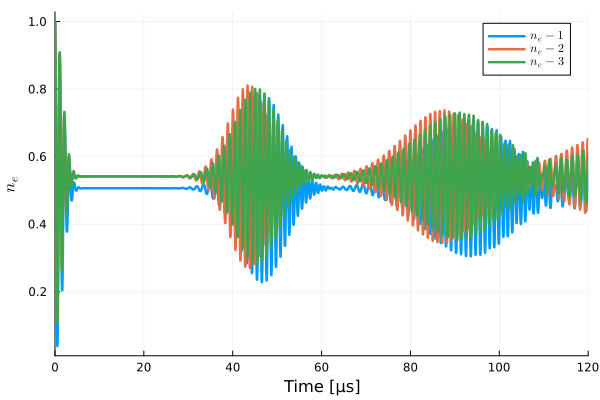

In [33]:
plot(tout1, real(expect(2, σp_qo*σm_qo, ψt1)), lw=2.5, label=L"n_e - 1"); 
plot!(tout2, real(expect(2, σp_qo*σm_qo, ψt2)), lw=2.5, label=L"n_e - 2");
plot!(tout3, real(expect(2, σp_qo*σm_qo, ψt3)), lw=2.5, label=L"n_e - 3");
#plot!(tout4, real(expect(2, σp_qo*σm_qo, ψt4)), lw=2.5, label=L"n_e - 4");

xlims!(0, 120μs)

xlabel!("Time [μs]")
ylabel!(L"$n_e$")

In [31]:
J_qc = collect(keys(γ_eff_2))

op_subs = base_qc .=> base_qo[1:5]
Jqo = []
Jqo_dagger = []
rates = []
for (J, γ) in γ_eff_2
    J1, J2 = J
    J1_qc = qnumber_to_qop(J1, op_subs, Id)
    J2_qc = qnumber_to_qop(J2, op_subs, Id)
    γ_qo = contraction_to_function(γ, ω_eff_2[J], p_sym)
    push!(rates, γ_qo)
    push!(Jqo, J1_qc)
    push!(Jqo_dagger, J2_qc)
end

function f(t, ρ; γ, args)
    rates = map(f -> f(args, t), γ)
    return (H_2(t, ρ), Jqo, Jqo_dagger, rates) 
end

f (generic function with 1 method)

### Solving using `QuantumCumulants.jl`

To solve, we start with defining a set of `QuantumCumulants.jl` variables into the Hamiltonian.

In [39]:
@cnumbers g_qc ωc_qc ωa_qc τ_qc
@syms t_qc::Real

subs = Dict(
    g => g_qc,
    ωc => ωc_qc,
    ωa => ωa_qc
)

# qc_convert should be deprecated
H_qc_1 = qc_convert(g_eff_1, Ω_eff_1, subs, t_qc, τ_qc)
H_qc_2 = [H_qc_1..., qc_convert(g_eff_2, Ω_eff_2, subs, t_qc, τ_qc)...]

15-element Vector{QuantumCumulants.QMul{Nothing}}:
 g_qc*exp((0 - 1im)*t_qc*(ωc_qc - ωa_qc))*exp(-0.5(τ_qc^2)*((ωc_qc - ωa_qc)^2))*(a′*σeg)
 g_qc*exp(-0.5(τ_qc^2)*((ωa_qc - ωc_qc)^2))*exp((0 - 1im)*t_qc*(ωa_qc - ωc_qc))*(a*σge)
 g_qc*exp((0 - 1im)*t_qc*(-ωa_qc - ωc_qc))*exp(-0.5(τ_qc^2)*((-ωa_qc - ωc_qc)^2))*(a*σeg)
 g_qc*exp(-0.5(τ_qc^2)*((ωa_qc + ωc_qc)^2))*exp((0 - 1im)*t_qc*(ωa_qc + ωc_qc))*(a′*σge)
 g_qc*exp(-0.5(τ_qc^2)*((ωa_qc + ωc_qc)^2))*exp((0 - 1im)*t_qc*(ωa_qc + ωc_qc))*(a′*σge)
 ((1//4)*(g_qc^2)*(1 / (ωc_qc - ωa_qc) + 1 / (-ωa_qc - ωc_qc))*exp(-0.5(τ_qc^2)*((ωa_qc + ωc_qc)^2 + (ωc_qc - ωa_qc)^2)) + (1//8)*(g_qc^2)*(-1 / (ωc_qc - ωa_qc) + -1 / (-ωa_qc - ωc_qc))*exp(-2.0(τ_qc^2)*(ωc_qc^2)))*exp((0 - 2im)*t_qc*ωc_qc)*(a′*a′)
 (1//2)*(((-1//4)*(g_qc^2)) / (ωa_qc + ωc_qc) + ((1//4)*(g_qc^2)) / (-ωa_qc - ωc_qc)) + (((1//4)*(g_qc^2)) / (ωa_qc - ωc_qc) + ((-1//4)*(g_qc^2)) / (ωc_qc - ωa_qc))*exp(-0.5(τ_qc^2)*((ωa_qc - ωc_qc)^2 + (ωc_qc - ωa_qc)^2)) + ((-1//4)*(g_qc^2)) / (ωa_qc + 

In [40]:
ops = [a, a'*a, σ(:e, :e), σ(:g, :g)]
eqs_1 = meanfield(ops, sum(H_qc_1), []; rates=[], order=2, iv=t_qc)
complete!(eqs_1)

∂ₜ(⟨a⟩) = (0 - 1im)*g_qc*⟨σeg⟩*exp((0 - 1im)*t_qc*(ωc_qc - ωa_qc) - 0.5(τ_qc^2)*((ωc_qc - ωa_qc)^2)) + (0 - 1im)*g_qc*⟨σge⟩*exp((0 - 1im)*t_qc*(ωa_qc + ωc_qc) - 0.5(τ_qc^2)*((ωa_qc + ωc_qc)^2))
∂ₜ(⟨a′*a⟩) = (0 - 1im)*g_qc*exp((0 - 1im)*t_qc*(ωa_qc + ωc_qc) - 0.5(τ_qc^2)*((ωa_qc + ωc_qc)^2))*⟨a′*σge⟩ + (0 - 1im)*g_qc*exp((0 - 1im)*t_qc*(ωc_qc - ωa_qc) - 0.5(τ_qc^2)*((ωc_qc - ωa_qc)^2))*⟨a′*σeg⟩ + (0 + 1im)*g_qc*exp((0 - 1im)*t_qc*(ωa_qc - ωc_qc) - 0.5(τ_qc^2)*((ωa_qc - ωc_qc)^2))*⟨a*σge⟩ + (0 + 1im)*g_qc*exp((0 - 1im)*t_qc*(-ωa_qc - ωc_qc) - 0.5(τ_qc^2)*((-ωa_qc - ωc_qc)^2))*⟨a*σeg⟩
∂ₜ(⟨σee⟩) = (0 + 1im)*g_qc*exp((0 - 1im)*t_qc*(ωa_qc + ωc_qc) - 0.5(τ_qc^2)*((ωa_qc + ωc_qc)^2))*⟨a′*σge⟩ + (0 - 1im)*g_qc*exp((0 - 1im)*t_qc*(ωc_qc - ωa_qc) - 0.5(τ_qc^2)*((ωc_qc - ωa_qc)^2))*⟨a′*σeg⟩ + (0 + 1im)*g_qc*exp((0 - 1im)*t_qc*(ωa_qc - ωc_qc) - 0.5(τ_qc^2)*((ωa_qc - ωc_qc)^2))*⟨a*σge⟩ + (0 - 1im)*g_qc*exp((0 - 1im)*t_qc*(-ωa_qc - ωc_qc) - 0.5(τ_qc^2)*((-ωa_qc - ωc_qc)^2))*⟨a*σeg⟩
∂ₜ(1 - ⟨σee⟩) = (

In [41]:
@named sys_1 = ODESystem(eqs_1)

Model sys_1 with 9 equations
States (9):
  var"⟨a⟩"(t_qc)
  var"⟨a′*a⟩"(t_qc)
  var"⟨σee⟩"(t_qc)
  var"1 - ⟨σee⟩"(t_qc)
⋮
Parameters (4):
  ωa_qc
  τ_qc
  ωc_qc
  g_qc

In [42]:
#u0 = ComplexF64[0, 0, 0.5, 0.5, 0, 0, 0, 0, 0]
#p0 = (ωa_qc=>1, ωc_qc=>1.1, g_qc=>0.2, τ_qc=>2)

# u0 = ComplexF64[0.1, 0.1^2, 1, 0, 0, 0, 0, 0.1^2, 0]

μs = 1
MHz = 1/μs

# state definition: ψ = cg|g> + ce|e>
ce_iv = 1/sqrt(2)
cg_iv = 1/sqrt(2)
a_iv = sqrt(4.5)

# initial values:
σee_iv = abs(ce_iv)^2
σgg_iv = abs(cg_iv)^2
σeg_iv = conj(ce_iv)*cg_iv
σge_iv = conj(cg_iv)*ce_iv

ω0 = 2MHz
δ = 0.1MHz

u0 = ComplexF64[a_iv, abs(a_iv*a_iv), σee_iv, σgg_iv, a_iv*σee_iv, σeg_iv, a_iv*σge_iv, a_iv^2, a_iv*σeg_iv]
p0 = (ωa_qc=>2π*(ω0 - δ/2), ωc_qc=>2π*(ω0 + δ/2), g_qc=>2π*0.1MHz, τ_qc =>0.2μs)

t1 = 2μs
t_list = range(0, t1, length=500)
prob_1 = ODEProblem(sys_1, u0, (0.0, t1), p0)

ODEProblem with uType Vector{ComplexF64} and tType Float64. In-place: true
timespan: (0.0, 2.0)
u0: 9-element Vector{ComplexF64}:
 2.1213203435596424 + 0.0im
  4.499999999999999 + 0.0im
                1.0 + 0.0im
                0.0 + 0.0im
 2.1213203435596424 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
  4.499999999999999 + 0.0im
                0.0 + 0.0im

In [43]:
sol_1 = solve(prob_1, RK4(), saveat=t_list)

retcode: Success
Interpolation: 1st order linear
t: 500-element Vector{Float64}:
 0.0
 0.004008016032064128
 0.008016032064128256
 0.012024048096192385
 0.01603206412825651
 0.02004008016032064
 0.02404809619238477
 0.028056112224448898
 0.03206412825651302
 0.036072144288577156
 ⋮
 1.967935871743487
 1.971943887775551
 1.9759519038076152
 1.9799599198396793
 1.9839679358717435
 1.9879759519038076
 1.9919839679358717
 1.9959919839679359
 2.0
u: 500-element Vector{Vector{ComplexF64}}:
 [2.1213203435596424 + 0.0im, 4.499999999999999 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im, 2.1213203435596424 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 4.499999999999999 + 0.0im, 0.0 + 0.0im]
 [2.1212921992419034 - 0.005300068650887074im, 4.499845912722954 - 5.659783507472798e-24im, 0.9998459118961803 - 5.1248880365657024e-24im, 0.00015408810381978212 + 5.1248880365657024e-24im, 2.1212757695666795 - 0.017185938255111013im, -0.0002523309531960033 + 0.05042892758063688im, 7.764527637077764e-5 - 0.061671149595869536im, 4.49

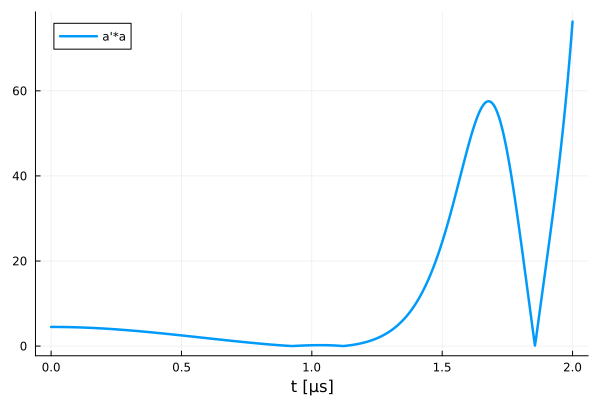

In [44]:
plot(t_list, abs.(sol_1[a'*a]), lw=2.5, label="a'*a")
xlabel!("t [μs]")

The cumulant approach seems to be ill-fitted for this parameter regime.